Import libraries

In [1]:
# Import all required libraries at the beginning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore') # Clean up the output by ignoring warnings

# Set plotting style for better visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Part 1: Data Loading and Basic Exploration

In [2]:
# Load the metadata.csv file into a Pandas DataFrame
# This might take a minute due to the file size
df = pd.read_csv('metadata.csv', low_memory=False)

print("✅ Data loaded successfully!")

#Examine the Data Structure
# Check the dimensions of the dataset (rows, columns)
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")

# Display the first 5 rows to get a feel for the data
print("\nFirst 5 rows of the dataset:")
df.head()
# Display column names and their data types
print("Dataset Info:")
df.info()

# Display column names and their data types
print("Dataset Info:")
df.info()

# Check for missing values
# Calculate missing values for each column
missing_data = df.isnull().sum()

# Display columns with missing values, sorted from highest to lowest
print("Missing values per column (top 20):")
missing_data[missing_data > 0].sort_values(ascending=False).head(20)

# Calculate the percentage of missing values for key columns
key_columns = ['title', 'abstract', 'authors', 'journal', 'publish_time']
missing_percentage = (df[key_columns].isnull().sum() / len(df)) * 100

print("Percentage of missing values in key columns:")
missing_percentage.sort_values(ascending=False)

# Show basic statistics for numerical columns
print("Basic statistics for numerical columns:")
df.describe()

✅ Data loaded successfully!
Dataset Shape: 1056660 rows, 19 columns

First 5 rows of the dataset:
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null  

,mag_id,s2_id
count,0.0,9.764680e+05
mean,NaN,2.175871e+08
std,NaN,5.312281e+07
min,NaN,9.600000e+01
25%,NaN,2.211411e+08
50%,NaN,2.320829e+08
75%,NaN,2.373948e+08
max,NaN,2.491936e+08


Part 2: Data Cleaning and Preparation

In [3]:
# Create a copy of the original DataFrame to clean
clean_df = df.copy()
print(f"Original shape: {clean_df.shape}")

# Drop rows where 'publish_time' is missing (crucial for time-based analysis)
clean_df = clean_df.dropna(subset=['publish_time'])
print(f"Shape after dropping rows with missing 'publish_time': {clean_df.shape}")

# Fill missing abstracts with an empty string
clean_df['abstract'] = clean_df['abstract'].fillna('')

# Fill missing journals with 'Unknown'
clean_df['journal'] = clean_df['journal'].fillna('Unknown')

# Convert 'publish_time' to datetime format, forcing errors to become NaT (Not a Time)
clean_df['publish_time'] = pd.to_datetime(clean_df['publish_time'], errors='coerce')

# Drop rows where the date conversion failed
initial_count = len(clean_df)
clean_df = clean_df.dropna(subset=['publish_time'])
final_count = len(clean_df)
print(f"Dropped {initial_count - final_count} rows due to invalid dates.")

# Extract the year from the publication date into a new column
clean_df['publication_year'] = clean_df['publish_time'].dt.year

# Display the range of publication years
print(f"Publication years range from {clean_df['publication_year'].min()} to {clean_df['publication_year'].max()}")

# Create a new column for abstract word count
clean_df['abstract_word_count'] = clean_df['abstract'].apply(lambda x: len(str(x).split()))

# Check the results of our cleaning
print("Cleaned dataset info:")
print(f"Final shape: {clean_df.shape}")
print("\nSample of prepared data:")
clean_df[['title', 'journal', 'publish_time', 'publication_year', 'abstract_word_count']].head()

Original shape: (1056660, 19)
Shape after dropping rows with missing 'publish_time': (1054846, 19)
Dropped 535975 rows due to invalid dates.
Publication years range from 1856 to 2024
Cleaned dataset info:
Final shape: (518871, 21)

Sample of prepared data:


,title,journal,publish_time,publication_year,abstract_word_count
0,Clinical features of culture-proven Mycoplasma...,BMC Infect Dis,2001-07-04,2001,262
1,Nitric oxide: a pro-inflammatory mediator in l...,Respir Res,2000-08-15,2000,142
2,Surfactant protein-D and pulmonary host defense,Respir Res,2000-08-25,2000,219
3,Role of endothelin-1 in lung disease,Respir Res,2001-02-22,2001,68
4,Gene expression in epithelial cells in respons...,Respir Res,2001-05-11,2001,110


Part 3: Data Analysis and Visualization

In [5]:
# Count papers by publication year
papers_by_year = clean_df['publication_year'].value_counts().sort_index()
print("Number of publications by year:")
print(papers_by_year)

# Identify top 10 journals
top_journals = clean_df['journal'].value_counts().head(10)
print("Top 10 journals by publication count:")
print(top_journals)

# Simple word frequency in titles (after removing NaNs)
from collections import Counter
all_titles = " ".join(title for title in clean_df['title'].dropna())
words = all_titles.split()
word_freq = Counter(words).most_common(20) # Top 20 most common words

print("Top 20 most frequent words in titles:")
for word, count in word_freq:
    print(f"{word}: {count}")

Number of publications by year:
publication_year
1856         3
1857         1
1860         2
1864         1
1876         1
         ...  
2020    164751
2021    219516
2022     85310
2023         1
2024         1
Name: count, Length: 75, dtype: int64
Top 10 journals by publication count:
journal
Unknown                            37185
bioRxiv                             8874
Int J Environ Res Public Health     8200
PLoS One                            7154
Sci Rep                             4160
Reactions Weekly                    3698
Front Psychol                       3265
BMJ                                 3003
Cureus                              2959
Front Immunol                       2674
Name: count, dtype: int64
Top 20 most frequent words in titles:
of: 349413
and: 269370
in: 251692
the: 209634
COVID-19: 134127
for: 102586
a: 100591
to: 78220
A: 72022
with: 69866
on: 57938
The: 43690
SARS-CoV-2: 37261
during: 33949
from: 30264
patients: 23837
by: 21211
study: 21129
pandemic

Create Visualizations

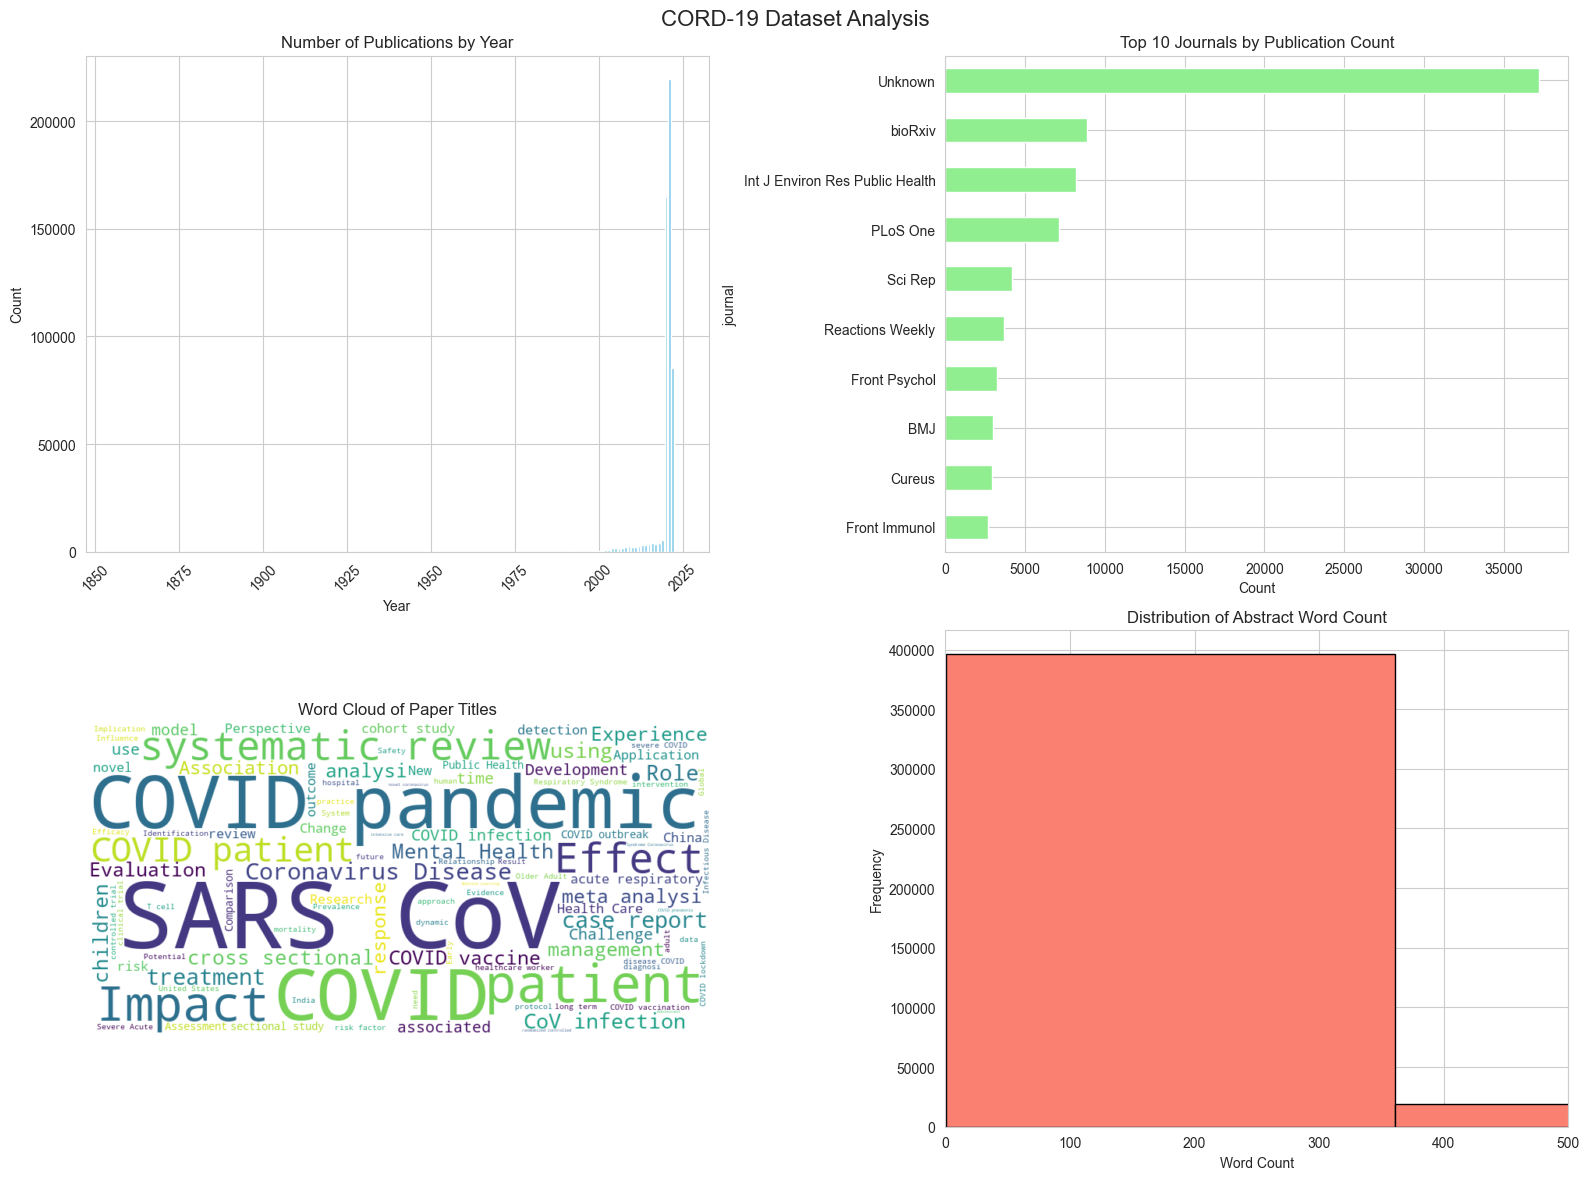

In [6]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CORD-19 Dataset Analysis', fontsize=16)

# Plot 1: Publications over time
axes[0, 0].bar(papers_by_year.index, papers_by_year.values, color='skyblue')
axes[0, 0].set_title('Number of Publications by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Top Journals (Horizontal Bar Chart)
top_journals.plot(kind='barh', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Top 10 Journals by Publication Count')
axes[0, 1].set_xlabel('Count')
axes[0, 1].invert_yaxis() # Highest count on top

# Plot 3: Word Cloud of Titles
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_titles)
axes[1, 0].imshow(wordcloud, interpolation='bilinear')
axes[1, 0].set_title('Word Cloud of Paper Titles')
axes[1, 0].axis('off')

# Plot 4: Distribution of abstract word count (for abstracts that exist)
has_abstract = clean_df[clean_df['abstract_word_count'] > 0]
axes[1, 1].hist(has_abstract['abstract_word_count'], bins=50, color='salmon', edgecolor='black')
axes[1, 1].set_title('Distribution of Abstract Word Count')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(0, 500) # Limit x-axis to see the distribution better

plt.tight_layout()
plt.savefig('cord19_analysis_visualizations.png', dpi=120, bbox_inches='tight')
plt.show()